# Imports

In [203]:
import importlib
import data_loading   # your file, e.g. court_listener_cleaner.py
import helper_functions
import scr.jp.features.labels
importlib.reload(scr.jp.features.labels)

<module 'scr.jp.features.labels' from '/Users/ilyadavidson/Stanford_Internship/judge_project/scr/jp/features/labels.py'>

In [296]:
# from data_loading import build_cap_dataset, _load_mapping, court_listener_cleaner, promotion_info_judges, scrape_third_circuit
from scr.jp.cap.data_loading import build_cap_dataset
from scr.jp.cl.extract import cl_loader
from scr.jp.features.labels import promotion_info_judges
from scr.jp.utils.io                 import _load_mapping
from helper_functions import judge_name_to_id
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import json
import pandas as pd
from typing import Dict, List, Optional
from scr.jp.api.results import attach_api_to_cl_clean, cap_data_cleaner, load_case_results 
import numpy as np
import os

import pyarrow.dataset as ds
import re, pandas as pd, unicodedata
import pyarrow.compute as pc
import tiktoken
import re
import unicodedata
import statsmodels.api as sm
from typing import Optional
from helper_functions import norm_id
from typing import Dict, List, Optional
import re, unicodedata
from functools import lru_cache
# from cl_data_maker import cl_loader, extract_district_judge_info

# Data loading

In [104]:
judges      = pd.read_csv("data/judge_info.csv")
judges      = promotion_info_judges(judges)
cap_data    = build_cap_dataset()

cl_data = pd.read_csv("data/artifacts/cl/third_circuit_cases.csv")
cl          = cl_loader(cl_data,judges) # get all the datapoints that scraper can find district judge for

def cap_data_cleaner(
    cap_df:             pd.DataFrame,
    mapping_path:       str = "data/artifacts/cap/appellate_matches2.json",   # appellate_custom_id -> district_unique_id
    api_path:           str = "batch_runs/api_responses.jsonl",
    *,
    id_col:             str = "unique_id",
    judge_name_col:     str = "opinion_author_clean",
    judge_id_col:       str = "opinion_author_id",
    case_name_col:      str = "name",
    docket_col:         str = "docket_number",
    opinion_text_col:   str = "opinion_text",
    decision_date_col:  str = "decision_date",
) -> pd.DataFrame:
    """
    Cleans CAP data and merges in district judge information and API answers.
    """

    app_to_dct             = _load_mapping(mapping_path)
    map_df                 = pd.DataFrame(list(app_to_dct.items()), columns=["custom_id", "district_uid"]).astype(str)

    # Keep only the original appellate cases present in mapping (keep their appellate metadata)
    out                    = cap_df.copy()
    out[id_col]            = out[id_col].astype(str)
    out                    = out[out[id_col].isin(map_df["custom_id"])].copy()

    # Attach appropriate district judge
    district_lookup = (
        cap_df[[id_col, judge_name_col, judge_id_col]]
        .drop_duplicates(subset=[id_col])
        .rename(columns={id_col:            "district_uid",
                         judge_name_col:    "district judge",
                         judge_id_col:      "district judge id"})
    )
    out = (
        out.merge(map_df, left_on=id_col, right_on="custom_id", how="left")
           .merge(district_lookup, on="district_uid", how="left")
    )

    # Get API answers
    api_answers                 = load_case_results(api_path) 
    api_answers                 = api_answers.copy()
    api_keys: List[str] = [c for c in api_answers.columns if c != "custom_id"]

    out                         = out.merge(api_answers, left_on="custom_id", right_on="custom_id", how="left")
    out[id_col]                 = "CAP_" + out["custom_id"].astype(str)

    out["district judge id"]    = pd.to_numeric(out["district judge id"], errors="coerce").astype("Int64") # 5.0 -> 5

    base_cols                   = [id_col, case_name_col, opinion_text_col, docket_col, "district judge", "district judge id", decision_date_col]

    exclude_cols                = {"lower_judge_first", "lower_judge_last"}
    api_cols                    = [c for c in api_keys if c in out.columns and c not in exclude_cols]

    keep_cols                   = [c for c in base_cols if c in out.columns] + api_cols

    return out[keep_cols].reset_index(drop=True)

cap_clean = cap_data_cleaner(cap_data)
thrd_judges = judges[judges['court name'].str.contains(r"Third|Delaware|New Jersey|Pennsylvania|Virgin Islands")]

/Users/ilyadavidson/Stanford_Internship/judge_project/scr/jp/features/labels.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aj["nomination date"] = pd.to_datetime(aj["nomination date"], errors="coerce")


Working dir: /Users/ilyadavidson/Stanford_Internship/judge_project
Found 28 parquet files for pattern: data/parquet_files/CAP_data_*.parquet


/Users/ilyadavidson/Stanford_Internship/judge_project/scr/jp/cl/extract.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cl_clean['is_appellate'] = 1
/Users/ilyadavidson/Stanford_Internship/judge_project/scr/jp/cl/extract.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cl_clean['unique_id'] = 'CL_' + cl_clean.index.astype(str)


In [381]:
cap_data

,name,docket_number,decision_date,court_name,jurisdiction,cite,cites_to,judges_raw,judges_clean,judges_ids,opinion_type,opinion_author_raw,opinion_author_clean,opinion_author_id,opinion_text,unique_id,is_appellate
0,"THE DELAWARE NATION, a Federally Recognized In...",No. 04-4593,2006-05-04,United States Court of Appeals for the Third C...,U.S.,446 Federal Reporter 3d Series 410,"542 F.Supp. 797, 524 U.S, 103, 164 F.Supp. 107...","Before ROTH, FUENTES, and GARTH, Circuit Judges.","[roth, fuentes, garth]","[2063, 2855, 823]",majority,"ROTH, Circuit. Judge.",roth,2063.0,"OPINION OF THE COURT\nROTH, Circuit. Judge.\nT...",0,1
1,"UNITED STATES of America v. Jason J. SMITH, Ap...",No. 05-2391,2005-07-29,United States Court of Appeals for the Third C...,U.S.,142 F. App'x 100,"28 U.S.C. § 1915, 208 Federal Reporter 3d Seri...","Before RENDELL, FISHER and VAN ANTWERPEN, Circ...","[rendell, fisher, van antwerpen]","[1992, 3047, 2437]",majority,PER CURIAM.,None,NaN,"OPINION\nPER CURIAM.\nAppellant, Jason J. Smit...",87542,1
2,AMERICAN STATES INSURANCE COMPANY v. Robert N....,No. 04-3245,2005-08-01,United States Court of Appeals for the Third C...,U.S.,142 F. App'x 104,"28 U.S.C. § 1332, 67 Federal Reporter 3d Serie...","Before SLOVITER, McKEE, & WEIS Circuit Judges.","[sloviter, mckee, weis]","[2208, 1563, 2540]",majority,"McKEE, Circuit Judge.",mckee,1563.0,"McKEE, Circuit Judge.\nRobert N. Hoden and Dia...",87544,1
3,"UNITED STATES of America v. Abraham Nee NTREH,...",No. 04-2993,2005-08-01,United States Court of Appeals for the Third C...,U.S.,142 F. App'x 106,"437 United States Reports 1, 430 United States...","Before NYGAARD, RENDELL, and SMITH, Circuit Ju...","[nygaard, rendell]","[1790, 1992]",majority,"SMITH, Circuit Judge.",None,NaN,"OPINION OF THE COURT\nSMITH, Circuit Judge.\nA...",87545,1
4,"CELLULAR TELEPHONE WIRELESS, d/b/a AT&T Wirele...",No. 04-3221,2005-08-01,United States Court of Appeals for the Third C...,U.S.,142 F. App'x 111,"324 N.J.Super. 149, 160 New Jersey Reports 1, ...","Before ROTH, FUENTES, and STAPLETON, Circuit J...","[roth, fuentes, stapleton]","[2063, 2855, 2275]",majority,"FUENTES, Circuit Judge.",fuentes,2855.0,"OPINION OF THE COURT\nFUENTES, Circuit Judge.\...",87546,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97426,UNITED STATES v. READING CO. et al.,No. 1095,1924-07-22,United States District Court for the Eastern D...,U.S.,300 Federal Reporter 477,"295 Fed. 551, 42 Sup. Ct. 547, 259 U. S. 156, ...",None,[],[],majority,"BUFFINGTON, Circuit Judge.",None,NaN,"BUFFINGTON, Circuit Judge.\nDuring the earlier...",84236,0
97427,In re DONALD SHOE CO.,No. 2689,1924-07-10,United States District Court for the Eastern D...,U.S.,300 Federal Reporter 559,"110 Pennsylvania State Reports 462, 92 Pennsyl...",None,[],[],majority,"THOMPSON, District Judge.",thompson,2376.0,"THOMPSON, District Judge.\nThe wage claims whi...",84237,0
97428,In re SHAPIRO et al.,No. 8250,1924-06-24,United States District Court for the Eastern D...,U.S.,300 Federal Reporter 566,"252 Fed. 183, 158 Fed. 788, 163 Fed. 135",None,[],[],majority,"THOMPSON, District Judge.",thompson,2376.0,"THOMPSON, District Judge.\nSamuel Shoyer was e...",84238,0
97429,HODGMAN et al. v. ATLANTIC REFINING CO. et al.,No. 452,1924-07-09,United States District Court for the District ...,U.S.,300 Federal Reporter 590,"274 Fed. 104, 30 Fed. 538, 52 L. R. A. 724, 46...",None,[],[],majority,"MORRIS, District Judge.",morris,1692.0,"MORRIS, District Judge.\nMarshall Hodgman and ...",84239,0


In [211]:
judges.columns

Index(['judge id', 'last name', 'first name', 'gender', 'ethnicity',
       'birth year', 'birth city', 'birth state', 'death year', 'death city',
       'death state', 'court name', 'court type', 'appointment title',
       'appointing president', 'party of appointing president',
       'nomination date', 'termination date', 'termination', 'aba rating',
       'hearing date', 'judiciary committee action', 'committee action date',
       'senate vote type', 'ayes/nays', 'confirmation date', 'commission date',
       'school 1', 'degree 1', 'school 2', 'degree 2', 'professional career',
       'is_promoted', 'promotion_date'],
      dtype='object')

In [5]:
cl_dockets = cl["docket_number"].dropna().astype(str).unique().tolist()
cap_dockets = cap_clean["docket_number"].dropna().astype(str).unique().tolist()

def has_overlap(cl_docket: str, cap_dockets=cap_dockets) -> bool:
    for cap_d in cap_dockets:
        if cl_docket in cap_d or cap_d in cl_docket:
            return True
    return False

cl["overlap_by_substring"] = cl["docket_number"].astype(str).apply(has_overlap)

total = len(cl)
overlap = cl["overlap_by_substring"].sum()
non_overlap = total - overlap

print(f"Total CourtListener cases: {total}")
print(f"Overlap by substring with CAP: {overlap}")
print(f"No overlap with CAP: {non_overlap}")

Total CourtListener cases: 9429
Overlap by substring with CAP: 476
No overlap with CAP: 8953


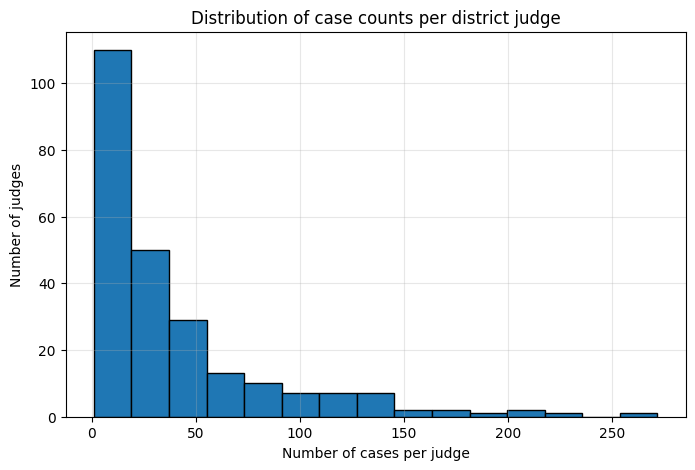

In [46]:
import pandas as pd
import matplotlib.pyplot as plt

# assuming your dataframe is cl_extracted (or similar)
df = cl.copy()

# count cases per judge id
cases_per_judge = (
    df['district judge id']
    .dropna()
    .astype(int)
    .value_counts()
)

# make a histogram (binning number of cases)
plt.figure(figsize=(8,5))
plt.hist(cases_per_judge, bins=15, edgecolor='black')
plt.xlabel("Number of cases per judge")
plt.ylabel("Number of judges")
plt.title("Distribution of case counts per district judge")
plt.grid(alpha=0.3)
plt.show()

In [105]:
def load_case_results(path: str = "data/artifacts/api/outputs/cl_api_answers.jsonl") -> pd.DataFrame:
    records = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            if not line.strip():
                continue
            rec = json.loads(line)
            if rec.get("error"):
                continue
            try:
                content = rec["response"]["body"]["choices"][0]["message"]["content"]
                obj = json.loads(content)  # parse the 9-key JSON
            except Exception:
                continue
            obj["custom_id"] = rec.get("custom_id")  # keep your custom_id
            records.append(obj)
    return pd.DataFrame.from_records(records)

def attach_api_to_cl_clean(
    cl_clean:           pd.DataFrame,
    api_path:           str = "data/artifacts/api/outputs/cl_api_answers.jsonl",
    judges:             pd.DataFrame = judges,
    *,
    id_col:             str = "unique_id",
    case_name_col:      str = "name",
    opinion_text_col:   str = "opinion_text",
    docket_col:         str = "docket_number",
    decision_date_col:  str = "decision_date",
) -> pd.DataFrame:
    out = cl_clean.copy()

    # Mirror unique_id -> custom_id so your merge block stays identical
    out["custom_id"] = (
    out["unique_id"]
    .astype("string")
)

    # Mirror unique_id -> custom_id so your merge block stays identical
    out["custom_id"] = (
    out["unique_id"]
    .astype("string")
)

    # === Use your exact merge logic ===
    api_answers                 = load_case_results(api_path)
    api_answers                 = api_answers.copy()
    api_keys: List[str]         = [c for c in api_answers.columns if c != "custom_id"]

    out                         = out.merge(api_answers, left_on="custom_id", right_on="custom_id", how="left")
    # DO NOT prefix CL ids (that's for CAP). Keep cl_clean's unique_id unchanged.
    # out[id_col]               = "CAP_" + out["custom_id"].astype(str)  # <-- intentionally NOT used

    if "district judge id" in out.columns:
        out["district judge id"] = pd.to_numeric(out["district judge id"], errors="coerce").astype("Int64")

    base_cols = [id_col, case_name_col, opinion_text_col, docket_col, "district judge", "district judge id", decision_date_col]

    exclude_cols = {"lower_judge_first", "lower_judge_last"}
    api_cols     = [c for c in api_keys if c in out.columns and c not in exclude_cols]

    keep_cols = [c for c in base_cols if c in out.columns] + api_cols
    return out[keep_cols].reset_index(drop=True)


In [ ]:
def get_id_from_names(out: pd.DataFrame, judges: pd.DataFrame) -> pd.Series:
    """
    Vectorized match: (lower_judge_first, lower_judge_last) in `out`
    -> 'judge id' from `judges`. Returns an Int64 Series aligned to `out.index`.
    """
    # Guard if name columns are missing
    if "lower_judge_first" not in out.columns or "lower_judge_last" not in out.columns:
        return pd.Series(pd.array([pd.NA] * len(out), dtype="Int64"), index=out.index)

    # Normalize judges names
    J = judges.copy()
    J["__fn"] = J["first name"].astype(str).str.strip().str.lower()
    J["__ln"] = J["last name"].astype(str).str.strip().str.lower()
    # Drop exact dup name pairs to avoid exploding matches
    J = J.drop_duplicates(subset=["__fn", "__ln"])

    # Normalize API-provided names
    L = out.copy()
    L["__fn"] = L["lower_judge_first"].astype(str).str.strip().str.lower()
    L["__ln"] = L["lower_judge_last"].astype(str).str.strip().str.lower()

    # Left-merge to get judge id
    M = L.merge(J[["__fn", "__ln", "judge id"]], on=["__fn", "__ln"], how="left")

    # Return aligned Series (nullable Int64)
    return pd.to_numeric(M["judge id"], errors="coerce").astype("Int64")

def attach_api_to_cl_clean(
    cl_clean:           pd.DataFrame,
    api_path:           str = "data/artifacts/api/outputs/cl_api_answers.jsonl",
    judges:             pd.DataFrame = judges,
    *,
    id_col:             str = "unique_id",
    case_name_col:      str = "name",
    opinion_text_col:   str = "opinion_text",
    docket_col:         str = "docket_number",
    decision_date_col:  str = "decision_date",
) -> pd.DataFrame:
    out = cl_clean.copy()
    out['district judge id'] = pd.NA
    out['district judge'] = pd.NA

    # Mirror unique_id -> custom_id so your merge block stays identical
    out["custom_id"] = (
    out["unique_id"]
    .astype("string")
)

    # === Use your exact merge logic ===
    api_answers                 = load_case_results(api_path)
    api_answers                 = api_answers.copy()
    api_keys: List[str]         = [c for c in api_answers.columns if c != "custom_id"]

    out                         = out.merge(api_answers, left_on="custom_id", right_on="custom_id", how="left")

    # get district judge ids and names from judges dataframe
    out['district judge'] = out['lower_judge_last'].apply(lambda x: x.lower().strip() if pd.notna(x) else "")
    out["district judge id"] = get_id_from_names(out, judges)
    
    mask = out["district judge id"].notna()
    out.loc[mask, "district judge"] = (
        out.loc[mask, "lower_judge_last"].astype(str).str.strip().str.lower()
    )


    if "district judge id" in out.columns:
        out["district judge id"] = pd.to_numeric(out["district judge id"], errors="coerce").astype("Int64")

    base_cols = [id_col, case_name_col, opinion_text_col, docket_col, "district judge", "district judge id", decision_date_col]

    exclude_cols = {"lower_judge_first", "lower_judge_last"}
    api_cols     = [c for c in api_keys if c in out.columns and c not in exclude_cols]

    keep_cols = [c for c in base_cols if c in out.columns] + api_cols
    return out[keep_cols].reset_index(drop=True)


In [260]:
cl_clean = attach_api_to_cl_clean(cl)

In [ ]:
cl_clean = cl_clean[cl_clean['district judge id'].notna()]
cl_clean = cl_clean[cl_clean['opinion'].notna()]

In [264]:
cl_clean

,unique_id,name,opinion_text,docket_number,district judge,district judge id,decision_date,opinion,case_type,error_category,petitioner_type,respondent_type,politicality_score,profile_level
0,CL_0,NRA Group LLC v. Nicole Durenleau,PRECEDE...,24-1123,wilson,7330451,2025-10-07,affirmed,civil,legal error,company,group of individuals,2.0,low
1,CL_1,Andrew Perrong v. Matthew Bradford,PRECEDENTIA...,24-1925,wolson,6385006,2025-10-06,reversed,civil,legal error,male,male,3.0,medium
2,CL_2,Novo Nordisk Inc v. Secretary US Dept & Health...,PRECEDEN...,24-2510,quraishi,10236621,2025-10-06,affirmed,civil,legal error,company,other,4.0,high
3,CL_3,United States v. Natalya Shvets,PRECEDEN...,22-2683,robreno,2033,2025-09-29,remanded,criminal,legal error,female,other,1.0,low
4,CL_4,Bobrick Washroom Equipment Inc v. Scranton Pro...,PRECED...,23-2577,mariani,3397,2025-09-26,affirmed,civil,procedural error,company,company,1.0,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9085,CL_30414,"Warren Webster, Jr. v. Clara v. Gideon and Fra...",213 F.2d 152\n\n54-2 USTC P 9435\n\nWarren WE...,11263-11265_1,madden,1458,1954-06-01,affirmed,civil,new or controlling precedent,group of individuals,group of individuals,1.0,low
9086,CL_30548,Laurie J. Carpenter v. Erie Railroad Company,"194 F.2d 289\n\nLaurie J. CARPENTER, Appellant...",10592_1,smith,2972,1952-04-17,affirmed,tort,None,None,company,1.0,medium
9088,CL_30567,Jacobs v. Ponnock,194 F.2d 534\n\nMilton Arthur JACOBS\nv.\nAbra...,10578_1,follmer,773,1952-02-27,affirmed,civil,insufficient evidence,male,group of individuals,1.0,low
9089,CL_30569,Union Paving Company v. Thomas,195 F.2d 184\n\nUNION PAVING COMPANY to the Us...,10607,welsh,2546,1952-02-26,affirmed,tort,insufficient evidence,company,group of individuals,1.0,low


In [265]:
def merge_cap_and_cl(cap: pd.DataFrame, cl: pd.DataFrame) -> pd.DataFrame:
    cap = cap.copy()
    cl  = cl.copy()

    # Normalize dockets for reliable matching
    cap["_dkey"] = cap["docket_number"].astype(str).str.strip()
    cl["_dkey"]  = cl["docket_number"].astype(str).str.strip()

    # Build fast lookup (first non-null per docket) for IDs and names from CL
    cl_id_map   = (cl[["_dkey", "district judge id"]]
                   .dropna(subset=["district judge id"])
                   .drop_duplicates("_dkey")
                   .set_index("_dkey")["district judge id"])
    cl_name_map = (cl[["_dkey", "district judge"]]
                   .dropna(subset=["district judge"])
                   .drop_duplicates("_dkey")
                   .set_index("_dkey")["district judge"])

    # Fill CAP's missing judge id/name from CL where dockets match
    miss_id = cap["district judge id"].isna()
    cap.loc[miss_id, "district judge id"] = cap.loc[miss_id, "_dkey"].map(cl_id_map)

    if "district judge" in cap.columns:
        miss_name = cap["district judge"].isna()
        cap.loc[miss_name, "district judge"] = cap.loc[miss_name, "_dkey"].map(cl_name_map)

    # Append CL rows that don't overlap by docket
    non_overlap_cl = cl[~cl["_dkey"].isin(cap["_dkey"])]
    non_overlap_cl = non_overlap_cl.reindex(columns=cap.columns, fill_value=np.nan)

    out = pd.concat([cap, non_overlap_cl], ignore_index=True)
    return out.drop(columns=["_dkey"], errors="ignore")

In [266]:
full_data = merge_cap_and_cl(cap_clean, cl_clean)

In [267]:
full_data

,unique_id,name,opinion_text,docket_number,district judge,district judge id,decision_date,opinion,case_type,error_category,petitioner_type,respondent_type,politicality_score,profile_level
0,CAP_87597,"PHILADELPHIA INDEMNITY INSURANCE COMPANY, Appe...","OPINION OF THE COURT\nSMITH, Circuit Judge.\nP...",No. 04-2667,NaN,<NA>,2005-07-27 00:00:00,affirmed,contract,legal error,company,company,1.0,medium
1,CAP_87739,"DIMENSIONAL COMMUNICATIONS, INC. v. OZ OPTICS,...","OPINION OF THE COURT\nPOLLAK, District Judge.\...",No. 04-1817,bassler,114,2005-08-12 00:00:00,affirmed,contract,abuse of discretion,company,company,1.0,low
2,CAP_87689,"Martin BRODY; Florence Brody; MFB Partners, L....","OPINION OF THE COURT\nSMITH, Circuit Judge.\nW...",No. 04-1376,joyner,1212,2005-08-29 00:00:00,reversed and remanded,civil,legal error,group of individuals,male,1.0,low
3,CAP_87025,LAW OFFICES OF CHRISTOPHER S. LUCAS & ASSOCIAT...,"OPINION OF THE COURT\nRENDELL, Circuit Judge.\...",No. 04-2695,jones,2946,2005-04-04 00:00:00,affirmed,civil,legal error,male,group of individuals,2.0,medium
4,CAP_87033,"Cynthia A. EBBERT, Appellant, v. DAIMLERCHRYSL...","OPINION OF THE COURT\nGREENBERG, Circuit Judge...",No. 04-2143,sleet,2772,2005-04-14 00:00:00,affirmed,civil,insufficient evidence,female,company,2.0,high
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7369,CL_30414,"Warren Webster, Jr. v. Clara v. Gideon and Fra...",213 F.2d 152\n\n54-2 USTC P 9435\n\nWarren WE...,11263-11265_1,madden,1458,1954-06-01,affirmed,civil,new or controlling precedent,group of individuals,group of individuals,1.0,low
7370,CL_30548,Laurie J. Carpenter v. Erie Railroad Company,"194 F.2d 289\n\nLaurie J. CARPENTER, Appellant...",10592_1,smith,2972,1952-04-17,affirmed,tort,None,None,company,1.0,medium
7371,CL_30567,Jacobs v. Ponnock,194 F.2d 534\n\nMilton Arthur JACOBS\nv.\nAbra...,10578_1,follmer,773,1952-02-27,affirmed,civil,insufficient evidence,male,group of individuals,1.0,low
7372,CL_30569,Union Paving Company v. Thomas,195 F.2d 184\n\nUNION PAVING COMPANY to the Us...,10607,welsh,2546,1952-02-26,affirmed,tort,insufficient evidence,company,group of individuals,1.0,low


In [268]:
full_data = full_data[full_data['opinion'].notna()]

In [269]:
full_data = full_data[full_data['district judge id'].notna()]

In [270]:
import pandas as pd, numpy as np

def compute_overturns(judges: pd.DataFrame, full_data: pd.DataFrame) -> pd.DataFrame:
    df = full_data.copy()
    df["judge id"]      = pd.to_numeric(df["district judge id"], errors="coerce").astype("Int64")
    df["opinion"]       = df["opinion"].astype(str).str.lower()
    df["decision_date"] = pd.to_datetime(df["decision_date"], errors="coerce")

    j = judges.copy()
    j["promotion_date"] = pd.to_datetime(j["promotion_date"], errors="coerce")
    j["cutoff"]         = j["promotion_date"] - pd.DateOffset(months=3)

    m = df.merge(j[["judge id","cutoff"]], on="judge id", how="inner")
    m = m[m["decision_date"].notna() & (m["cutoff"].isna() | (m["decision_date"] <= m["cutoff"]))]

    counts = m.groupby("judge id", dropna=True).agg(
        appealed_cases=("unique_id","count"),
        overturned_appealed_cases=("opinion", lambda x: (x != "affirmed").sum())
    )

    out = j.merge(counts, on="judge id", how="left")
    out[["appealed_cases","overturned_appealed_cases"]] = out[["appealed_cases","overturned_appealed_cases"]].fillna(0).astype(int)
    out["overturnrate"] = np.where(out["appealed_cases"] > 0,
                                   out["overturned_appealed_cases"] / out["appealed_cases"], np.nan)
    return out

In [272]:
feature_dataset = compute_overturns(judges, full_data)

In [274]:
import pandas as pd
import numpy as np

def compute_judge_features(
    judges: pd.DataFrame,
    full_data: pd.DataFrame,
    *,
    opinion_col: str = "opinion",
    affirmed_label: str = "affirmed",
    score_col: str = "politicality_score",
) -> pd.DataFrame:
    """
    Adds to `judges`:
      - appealed_cases
      - overturned_appealed_cases
      - overturnrate
      - avg_politicality
      - n_scored_cases

    Only counts cases decided on/before cutoff (promotion_date - 3 months).
    """

    # --- normalize case data ---
    df = full_data.copy()
    df["judge id"]      = pd.to_numeric(df.get("district judge id"), errors="coerce").astype("Int64")
    df["decision_date"] = pd.to_datetime(df.get("decision_date"), errors="coerce")
    # opinion & score
    df[opinion_col]     = df.get(opinion_col, pd.Series(index=df.index, dtype="object")).astype(str).str.lower()
    df[score_col]       = pd.to_numeric(df.get(score_col), errors="coerce")

    # --- normalize judges & cutoff ---
    j = judges.copy()
    j["promotion_date"] = pd.to_datetime(j.get("promotion_date"), errors="coerce")
    j["cutoff"]         = j["promotion_date"] - pd.DateOffset(months=3)

    # --- join cases to judges & apply cutoff ---
    m = df.merge(j[["judge id", "cutoff"]], on="judge id", how="inner")
    m = m[m["decision_date"].notna() & (m["cutoff"].isna() | (m["decision_date"] <= m["cutoff"]))]

    # --- aggregate by judge ---
    agg = (
        m.groupby("judge id", dropna=True)
         .agg(
             appealed_cases=("unique_id", "count"),
             overturned_appealed_cases=(opinion_col, lambda x: (x != str(affirmed_label).lower()).sum()),
             avg_politicality=(score_col, lambda x: np.nanmean(x) if x.notna().any() else np.nan),
             n_scored_cases=(score_col, lambda x: x.notna().sum()),
         )
         .reset_index()
    )

    # --- merge back & finalize ---
    out = j.merge(agg, on="judge id", how="left")
    for c in ["appealed_cases", "overturned_appealed_cases", "n_scored_cases"]:
        out[c] = out[c].fillna(0).astype(int)

    out["overturnrate"] = np.where(
        out["appealed_cases"] > 0,
        out["overturned_appealed_cases"] / out["appealed_cases"],
        np.nan,
    )

    return out

In [275]:
feature_dataset = compute_judge_features(judges, full_data)

In [276]:
feature_dataset = feature_dataset[feature_dataset["appealed_cases"] > 0]

In [313]:
feature_dataset['aba rating'].isna().sum()

np.int64(78)

In [318]:
len(feature_dataset[(feature_dataset['is_promoted']==1)]['aba rating'])

27

In [325]:
len(thrd_judges)

333

In [338]:
len(judges[(judges['aba rating']==3)&(judges['is_promoted']==0)]) 

5

In [341]:
len(judges)

3277

In [377]:
thrd_judges['aba rating'].value_counts()

aba rating
2.0    138
1.0     75
3.0      1
Name: count, dtype: int64

In [364]:
thrd_judges['aba rating'].unique()

array([nan,  2.,  1.,  3.])

In [378]:
thrd_judges[(thrd_judges['aba rating']==3)&(thrd_judges['is_promoted']==0)]

,judge id,last name,first name,gender,ethnicity,birth year,birth city,birth state,death year,death city,...,ayes/nays,confirmation date,commission date,school 1,degree 1,school 2,degree 2,professional career,is_promoted,promotion_date
1990,1302,knox,William,Male,White,1911,Erie,PA,1981.0,Erie,...,,1970-10-08,1970-10-14,University of Michigan,A.B.,University of Michigan Law School,J.D.,"Private practice, Erie, Pennsylvania, 1935-1970",0,NaT


In [304]:
feature_dataset.columns

Index(['judge id', 'last name', 'first name', 'gender', 'ethnicity',
       'birth year', 'birth city', 'birth state', 'death year', 'death city',
       'death state', 'court name', 'court type', 'appointment title',
       'appointing president', 'party of appointing president',
       'nomination date', 'termination date', 'termination', 'aba rating',
       'hearing date', 'judiciary committee action', 'committee action date',
       'senate vote type', 'ayes/nays', 'confirmation date', 'commission date',
       'school 1', 'degree 1', 'school 2', 'degree 2', 'professional career',
       'is_promoted', 'promotion_date', 'cutoff', 'appealed_cases',
       'overturned_appealed_cases', 'avg_politicality', 'n_scored_cases',
       'overturnrate'],
      dtype='object')

In [379]:
fts = feature_dataset.copy()

# 1. Target and base numeric features
####################################################################################
y       = fts["is_promoted"].astype(float)  

X       = pd.DataFrame({
    "overturnrate": pd.to_numeric(fts["overturnrate"], errors="coerce"),
    # "average_politicality": pd.to_numeric(fts["avg_politicality"], errors="coerce"),
})

# 2. Categorical features (one-hot encoded)
####################################################################################
# gnd_dm      = pd.get_dummies(fts["gender"], prefix="gender", drop_first=True, dtype=float)
prty_dm     = pd.get_dummies(fts['party of appointing president'], prefix='party', drop_first=True, dtype=float)
eth_dm      = pd.get_dummies(fts['ethnicity'], prefix='eth' , drop_first=True, dtype=float)
aba_num     = pd.to_numeric(fts['aba rating'], errors="coerce").fillna(2)
aba_dm      = pd.get_dummies(aba_num.astype("category"), prefix="ABA", drop_first=True, dtype=float)

X = pd.concat([X, eth_dm, aba_dm, prty_dm], axis=1)
X = X.apply(pd.to_numeric, errors="coerce")

X = sm.add_constant(X, has_constant="add")

# 3. Regression models
####################################################################################
logit_model = sm.Logit(y, X).fit(maxiter=100)
print("=== Logistic Regression: is promoted ~ overturnrate + gender + ethnicity ===")
print(logit_model.summary())

ols_model = sm.OLS(y, X).fit(maxiter=100)
print("\n=== OLS Regression: is promoted ~ overturnrate + gender + ethnicity ===")
print(ols_model.summary())

         Current function value: 0.305025
         Iterations: 100
=== Logistic Regression: is promoted ~ overturnrate + gender + ethnicity ===
                           Logit Regression Results                           
Dep. Variable:            is_promoted   No. Observations:                  272
Model:                          Logit   Df Residuals:                      259
Method:                           MLE   Df Model:                           12
Date:                Fri, 10 Oct 2025   Pseudo R-squ.:                 0.05701
Time:                        16:10:31   Log-Likelihood:                -82.967
converged:                      False   LL-Null:                       -87.982
Covariance Type:            nonrobust   LLR p-value:                    0.6132
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          -

/Users/ilyadavidson/Stanford_Internship/judge_project/env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
